# Data Reconciliation of a Supercritical Coal-Fired Boiler, Flowsheet  Example

This notebook demonstrates data reconciliation with a flowsheet heat exchanger network, the boiler subflowsheet consist of an economizer, water wall, primary superheater, platen superheater, finishing superheater, and reheater.  Data for this example was generated by adding noise to supercritical power plant simulations.

### Why reconcile data?

Data reconciliation uses mass and energy balances along with redundant measurements to improve data quality by:

1. reducing measurement error,
2. ensuring measurements satisfy mass and energy balances, and
3. filling in unmeasured quantities.

Data reconciliation is used to refine process data before parameter estimation.

## 1.  Read Plant Data

The first step is to read in process data.  In this case, data was simulated by adding measurement error to supercritical steam cycle simulation results.  IDAES includes functions to read process data, convert units to match the models, and map data to the model.

In [1]:
# IDAES module with functions to read, analyze and visualize plant data
import idaes.core.dmf.model_data as da

Process data is contained in two csv files, a data file and a metadata file.  The data file where the first column is row indexes and the first row is process measurement tags.  The index column has an entry for each data row, and is often a timestamp.  The metadata file contains information about the tags including units of measurement, description, and model mapping information.

Once the process data is read in, the data is assigned to bins based on the value in a given column, in this case gross power. Dividing the data into bins allows rough estimation of measurement uncertainty.

In [2]:
# Read in data and column metadata
df, df_meta = da.read_data("plant_data.csv", "plant_data_meta.csv")
# Add bin information where the data is sorted into 5 MW bins based on the "GROSS_POWER" column
bin_count = da.bin_data(df, bin_by="POWER_GROSS", bin_no="bin_no", bin_nom="bin_power", bin_size=5e6)
# Calculate the standard deviation by bin for each column
bin_stdev = da.bin_stdev(df, bin_no="bin_no")

It can be useful to visualize the measurement data and estimated uncertainty.  The following creates box and whisker plots for each tag based on the data bins.

In [3]:
# Create a pdf book of plots that shows box and whisker plots for each column by bin
import os
if not os.path.isfile("data_plot_book.pdf"):
    da.data_plot_book(df, file="data_plot_book.pdf", bin_nom="bin_power", xlabel="gross power (W)", metadata=df_meta)
# There should now be a data_plot_book.pdf file in this directory

## 2.  Boiler Flowsheet Setup

Now that we have the plant data, we need to create the flowsheet model that we can use for data reconciliation. Although we need a model that has just mass and energy balances and feasibility constraints for the data reconciliation problem, we start with the boiler flowsheet model here.  Using the same model for data reconciliation, parameter estimation, validation, and simulation reduces the work required to move between steps in the workflow.

Once the full flowsheet model is created, constraints that are not needed for data reconciliation can be deactivated.

### 2.1 Case Study:
In a supercritical coal-fired power plant, the boiler sub-system consists of multiple heat exchangers transferring heat from the combustion side to the water/steam side. The boiler system for this work (Figure 1) is based on a 550 MWe supercritical power plant. Note that water wall and platen superheater are modeled as a heater, while the rest of the units correspond to the shell and tube heat exchangers.
Note that boiler flowsheet block diagram shows the available measurements from plant data. *for demonstration purposes "plant data" has been trained at different operating loads and with noise.

<img src="boiler_flowsheet.png"/>

In [4]:
# Import pyomo and idaes libraries
from idaes.core.util import model_serializer as ms
from idaes.core.util.model_statistics import degrees_of_freedom

import pyomo.environ as pyo

# import methods to build the flowsheet and deactivate performance constraints
import boiler_data_rec as flowsheet

### 2.2 Flowsheet Setup
The "boiler_flowsheet" method imports all the unit models in the boiler heat exchanger network, builds the flowsheet, builds the flowsheet connectivity, and initializes the flowsheet.

The final solve corresponds to a simulation case, with the following inputs (relative to a ~650 MW case):
- Economizer (water): F, h, P
- Reheater Inlet (Cold Reheat steam): F, h, P
- Coal flowrate (kg/s) and stoichiometric ratio (unitless)
- Dimensions of all units (tube diameter, # tubes, hx area, etc.)

In [5]:
# Create boiler flowsheet, the main unit models are: 
# heat exchanger model: economizer, primary super heater, finishing superheater, and reheater
# heater model: water wall and platen superheater

m = flowsheet.boiler_flowsheet()

57072.56349970795
2022-09-22 09:22:15 [INFO] idaes.init.fs.ECON.cold_side: Initialization Complete
2022-09-22 09:22:15 [INFO] idaes.init.fs.ECON.hot_side.properties_in: Initialisation Complete, optimal - Optimal Solution Found.
2022-09-22 09:22:15 [INFO] idaes.init.fs.ECON.hot_side.properties_out: Initialisation Complete, optimal - Optimal Solution Found.
2022-09-22 09:22:15 [INFO] idaes.init.fs.ECON.hot_side.properties_out: fs.ECON.hot_side.properties_out State Released.
2022-09-22 09:22:15 [INFO] idaes.init.fs.ECON.hot_side: Initialization Complete
2022-09-22 09:22:15 [INFO] idaes.init.fs.ECON: fs.ECON Initialisation Step 1 Complete.
2022-09-22 09:22:15 [INFO] idaes.init.fs.ECON.hot_side.properties_in: fs.ECON.hot_side.properties_in State Released.
2022-09-22 09:22:15 [INFO] idaes.init.fs.ECON: fs.ECON Initialisation Complete.
2022-09-22 09:22:15 [INFO] idaes.init.fs.PrSH.cold_side: Initialization Complete
2022-09-22 09:22:15 [INFO] idaes.init.fs.PrSH.hot_side.properties_in: Initiali


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 330
  Number of variables: 330
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.11064267158508301
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

degrees of freedom = 0
2022-09-22 09:22:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.ECON.hot_side.heat
2022-09-22 09:22:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.ECON.cold_side.heat
2022-09-22 09:22:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.ECON.overall_heat_transfer_coefficient[0.0]
2022-09-22 09:22:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.ECON.area
2022-09-22 09:22:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.ECON.overall_heat_transfer_coefficient[0.0]
2022-09-22 09:22:17 [WARNING] idaes.co

In [6]:
import pytest
assert pyo.value(m.fs.coal_flow) == pytest.approx(50.15, rel=1e-4)
assert pyo.value(m.fs.PlSH.heat_duty[0]) == pytest.approx(88880834.87, rel= 1e-3)

## 3.  Simplify to Mass and Energy Balances

For data reconciliation, the flowsheet model should be reduced to mass and energy balances and potentially limited performance constraints to keep the results feasible.

In [7]:
# Deactivate constraints for heat transfer (for all heat exchanger units)
# for example to deactivate heat transfer calculation in the economizer we include:
# m.fs.ECON.overall_heat_transfer_coefficient_eqn.deactivate()

# The method "deactivate_performance_constraints" deactivates the equations for all 
# heat exchangers in this flowsheet (Economizer, Primary Superheater, 
#                                    Finishing Superheater, Reheater)
flowsheet.deactivate_performance_constraints(m)

# Now the model has 12 DoF 
# deltaP shell and tube, and U - overall heat transfer coefficient in 4 hx models

degrees of freedom = 12


In [8]:
assert degrees_of_freedom(m) == pytest.approx(12, rel=1e-4)

## 4. Map Data to the Model

Although the model mapping can be added to the tag metadata file, here we just add the mapping information to the tag metadata after reading the data.

In [9]:
# Water/Steam Measurements ----------------------------------------------- #
# Economizer inputs
df_meta["BFW_F"]["reference_string"] = "m.fs.ECON.cold_side.properties_in[:].flow_mol"
df_meta["BFW_T"]["reference_string"] = "m.fs.ECON.cold_side.properties_in[:].temperature"
df_meta["BFW_P"]["reference_string"] = "m.fs.ECON.cold_side.properties_in[:].pressure"

# Economizer outputs
df_meta["ECON_OUT_T"]["reference_string"] = "m.fs.ECON.cold_side.properties_out[:].temperature"
df_meta["ECON_OUT_P"]["reference_string"] = "m.fs.ECON.cold_side.properties_out[:].pressure"

# Reheater inputs 
df_meta['RHT_COLD_T']["reference_string"] = "m.fs.RH.cold_side.properties_in[:].temperature"
df_meta['RHT_COLD_P']["reference_string"] = "m.fs.RH.cold_side.properties_in[:].pressure"
df_meta['RHT_COLD_F']["reference_string"] = "m.fs.RH.cold_side.properties_in[:].flow_mol"

# Reheater outputs 
df_meta['RHT_HOT_T']["reference_string"] = "m.fs.RH.cold_side.properties_out[:].temperature"
df_meta['RHT_HOT_P']["reference_string"] = "m.fs.RH.cold_side.properties_out[:].pressure"

# primary SH outlet
df_meta['PlatenSH_IN_P']["reference_string"] = "m.fs.PrSH.cold_side.properties_out[:].pressure"

# Platen SH outlet inlet to Finishing SH
df_meta['FSH_In_P']["reference_string"] = "m.fs.PrSH.cold_side.properties_in[:].pressure"

# Finishing SH outlet ----------------------------------------------------- #
# Main Steam 
df_meta['MS_T']["reference_string"] = "m.fs.ATMP1.mixed_state[:].temperature"
df_meta['MS_P']["reference_string"] = "m.fs.ATMP1.mixed_state[:].pressure"
df_meta['MS_F']["reference_string"] = "m.fs.ATMP1.mixed_state[:].flow_mol"

# Flue Gas measurements
# Finishing inputs
df_meta['FG_2_FSH_Fm']["reference_string"] = "m.fs.FSH.hot_side.properties_in[:].flow_mass"
df_meta['FG_2_FSH_T']["reference_string"] = "m.fs.FSH.hot_side.properties_in[:].temperature"
df_meta['FG_2_FSH_P']["reference_string"] = "m.fs.FSH.hot_side.properties_in[:].pressure"

# Reheater inputs
df_meta['FG_2_RH_T']["reference_string"] = "m.fs.RH.hot_side.properties_in[:].temperature"
df_meta['FG_2_RH_P']["reference_string"] = "m.fs.RH.hot_side.properties_in[:].pressure"

# Primary SH inputs
df_meta['FG_2_PrSH_Fm']["reference_string"] = "m.fs.PrSH.hot_side.properties_in[:].flow_mass"
df_meta['FG_2_PrSH_T']["reference_string"] = "m.fs.PrSH.hot_side.properties_in[:].temperature"
df_meta['FG_2_PrSH_P']["reference_string"] = "m.fs.PrSH.hot_side.properties_in[:].pressure"

# Economizer inputs
df_meta["FG_2_ECON_P"]["reference_string"] = "m.fs.ECON.hot_side.properties_in[:].pressure"

# Economizer outputs
df_meta["FG_2_AIRPH_T"]["reference_string"] = "m.fs.ECON.hot_side.properties_out[:].temperature"
df_meta["FG_2_AIRPH_P"]["reference_string"] = "m.fs.ECON.hot_side.properties_out[:].pressure"

# --------------------------------------------------------------------------------------- #
# Other inputs available in the data set (but not used as measurements in this study)
df_meta["ECON_OUT_F"]["reference_string"] = "m.fs.ECON.cold_side.properties_out[:].flow_mol"
df_meta['RHT_HOT_F']["reference_string"] = "m.fs.RH.cold_side.properties_out[:].flow_mol"
df_meta['FG_2_RH_Fm']["reference_string"] = "m.fs.RH.hot_side.properties_in[:].flow_mass"
df_meta["FG_2_ECON_Fm"]["reference_string"] = "m.fs.ECON.hot_side.properties_in[:].flow_mass"
df_meta["FG_2_ECON_T"]["reference_string"] = "m.fs.ECON.hot_side.properties_in[:].temperature"
df_meta["FG_2_AIRPH_Fm"]["reference_string"] = "m.fs.ECON.hot_side.properties_out[:].flow_mass"

df_meta['FG_RH_2_Mix_Fm']["reference_string"] = "m.fs.RH.hot_side.properties_out[:].flow_mass"
df_meta['FG_RH_2_Mix_T']["reference_string"] = "m.fs.RH.hot_side.properties_out[:].temperature"
df_meta['FG_RH_2_Mix_P']["reference_string"] = "m.fs.RH.hot_side.properties_out[:].pressure"

df_meta['FG_PrSH_2_Mix_Fm']["reference_string"] = "m.fs.PrSH.hot_side.properties_out[:].flow_mass"
df_meta['FG_PrSH_2_Mix_T']["reference_string"] = "m.fs.PrSH.hot_side.properties_out[:].temperature"
df_meta['FG_PrSH_2_Mix_P']["reference_string"] = "m.fs.PrSH.hot_side.properties_out[:].pressure"

df_meta['FG_2_ECON_Fm']["reference_string"] = "m.fs.ECON.hot_side.properties_in[:].flow_mass"
df_meta['FG_2_ECON_T']["reference_string"] = "m.fs.ECON.hot_side.properties_in[:].temperature"
df_meta['FG_2_ECON_P']["reference_string"] = "m.fs.ECON.hot_side.properties_in[:].pressure"

df_meta['FG_2_AIRPH_Fm']["reference_string"] = "m.fs.ECON.hot_side.properties_out[:].flow_mass"
df_meta['FG_2_AIRPH_T']["reference_string"] = "m.fs.ECON.hot_side.properties_out[:].temperature"
df_meta['FG_2_AIRPH_P']["reference_string"] = "m.fs.ECON.hot_side.properties_out[:].pressure"

In [10]:
# Add the model references to the tag metadata based on the strings above.
da.upadate_metadata_model_references(m, df_meta)

In [11]:
# Create a ModelTagGroup to hold the references that we want to use for the data reconciliation problem.  
# The name is the tag and the expr is a reference to a quantity in the model.
from idaes.core.util.tags import ModelTagGroup

data_tags = ModelTagGroup()

for k, v in df_meta.items():
    if v["reference"] is not None:
        data_tags.add(expr=v["reference"][0], name=k, format_string="{:.3f}")

In [12]:
# The output from the data reconciliation step usually gives full stream information
# for a flowsheet including quantities that are unmeasured. To use the results more easily, 
# it is good practice to map most of the data reconciliation results to flowsheet stream names.
import idaes.core.util.tables as ta
from idaes.core.util.tags import ModelTagGroup

stream_dict = ta.arcs_to_stream_dict(
    m, 
    additional={
        'MS': m.fs.ATMP1.mixed_state,
        'ATMP_In': m.fs.FSH.cold_side.properties_out,
        'FSH_In': m.fs.FSH.cold_side.properties_in,
        'PrSH_IN': m.fs.PrSH.cold_side.properties_in,
        'RHT_COLD': m.fs.RH.cold_side.properties_in,
        'RHT_HOT': m.fs.RH.cold_side.properties_out,
        'PlatenSH_IN': m.fs.PlSH.control_volume.properties_in,
        'BFW': m.fs.ECON.cold_side.properties_in,
        'ECON_OUT': m.fs.ECON.cold_side.properties_out,
        'FG_2_FSH': m.fs.FSH.hot_side.properties_in,
    },
    sort=True,
)

state_dict = ta.stream_states_dict(stream_dict, time_point=0)

recon_tags = ModelTagGroup()

prop_dict = {
    "flow_mass": "_Fm",
    "flow_mol": "_F",
    "enth_mol": "_h",
    "temperature": "_T",
    "pressure": "_P",
}
comp_list = ["O2", "NO", "N2", "SO2", "CO2", "H2O"]

for state, block in state_dict.items():
    for prop, suffix in prop_dict.items():
        comp = getattr(block, prop)
        recon_tags.add(expr=comp, name=state+suffix, format_string="{:.3f}")
    # Add tags for molar flow rates of each component
    for j in comp_list:
        # Not all components appear in all streams
        try:
            comp = block.flow_mol_comp[j]
            recon_tags.add(expr=comp, name=f"{state}_F[{j}]", format_string="{:.3f}")
        except KeyError:
            pass

# add additional model variables
recon_tags.add("coal_flow", m.fs.coal_flow, format_string="{:.3f}")
recon_tags.add("stoich_ratio", m.fs.SR, format_string="{:.3f}")

## 5. View Model Flowsheet

Model results or other quantities can be added to a process flow diagram. The PFD was drawn beforehand and the model results are added to tagged locations on the PFD.

In [13]:
from idaes.core.util.tags import svg_tag  # utility to place numbers/text in an SVG

with open("Boiler_scpc_PFD.svg", "r") as f:
    s = svg_tag(svg=f, tag_group=data_tags, outfile="boiler_scpc_init.svg")

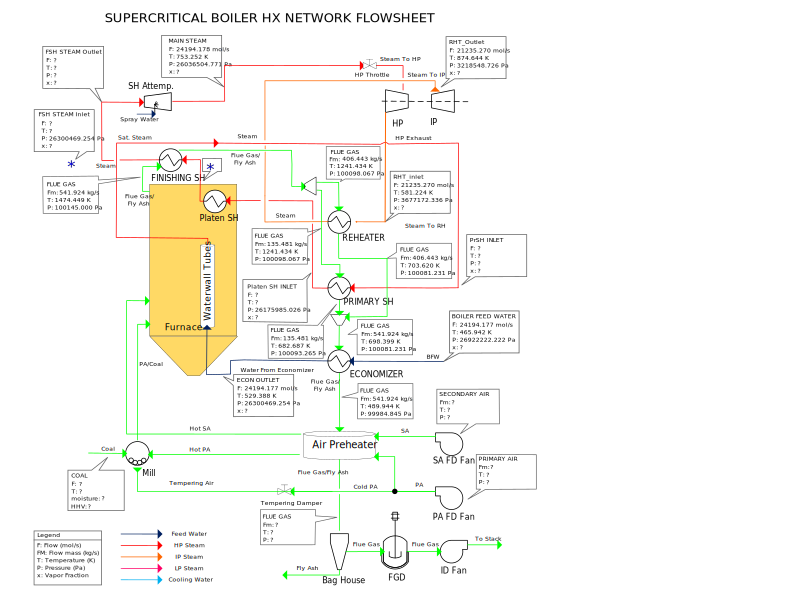

In [14]:
from IPython.display import SVG, display

display(SVG(s))

## 6.  Write Objective

Next we write the objective function and additional constraints for the data reconciliation problem.  The objective is

$$\min \sum_i \left(\frac{x_{\text{data}, i} - x_{\text{model}, i}}{\sigma_i} \right)^2$$

Where $i \in \{\text{Measured Quantities}\}$ and $\sigma_i$ is the standard deviation of measurement i estimated by binning the data.

In [15]:
# Add model parameters to contain measured data.  These are mutable so we can set a specific 
# change to specific data points later.
m.data = pyo.Param(data_tags, mutable=True, doc="Process data for a specific point in time.")
m.data_stdev = pyo.Param(data_tags, mutable=True, doc="Process data standard deviation.")

In [16]:
# The 'set_data' function below takes data from the model DataFrame and updates the
# model data parameters.
# fix tags dictionary is used to fix model inputs to their values in the data set (for each data point)
# in this case Boiler Feed Water = inlet to economizer and Reheater Cold = Reheater inlet
def set_data(m, df, data_tags, index=None, indexindex=None):
    if index is None:
        index = df.index[indexindex]
    m.bin_no = df.iloc[index]["bin_no"]
    for t in data_tags:
        m.data[t] = df.iloc[index][t]
        m.data_stdev[t] = bin_stdev[m.bin_no][t]

In [17]:
# So we have something reasonable to start, set the data attached to the model to the first 
# data point.
set_data(m, df, data_tags, indexindex=0)

Add an expression for error divided by the standard deviation, and use it to write the data reconciliation objective function.

In [18]:
m.tags_obj = [
    'BFW_F', 
    'BFW_T', 
    'BFW_P',        
    "RHT_COLD_F", 
    "RHT_COLD_T", 
    "RHT_COLD_P",
    "ECON_OUT_T",
    "ECON_OUT_P",
    "RHT_HOT_T",
    "RHT_HOT_P",
    "MS_T", 
    "MS_P", 
    "FG_2_ECON_P",
    "FG_2_AIRPH_T",
    "FG_2_AIRPH_P",
    "FG_RH_2_Mix_T",
    "FG_RH_2_Mix_P",
    "FG_RH_2_Mix_Fm",
    "FG_2_FSH_P",
    "FG_2_FSH_T",
    "FG_PrSH_2_Mix_T",
    "FG_PrSH_2_Mix_P",
    "FG_PrSH_2_Mix_Fm",
]

@m.Expression(data_tags)
def err(m, i):
    return (m.data[i] - data_tags[i].expression)/m.data_stdev[i]

m.objective = pyo.Objective(expr=sum(m.err[t]**2 for t in data_tags))

## 7. Solve Optimization

Now we need to solve the data reconciliation problem for every data point.  The important results are stored in two DataFrames ```df_result``` which contains results tagged based on model stream names to be used in the parameter estimation step and ```df_result_cmp``` which contains reconciled data based on the original measurement tags and can be used to compare the original measurements to the reconciled results.

In [19]:
# Add constraints or fix variable bounds to ensure reasonable flowsheet performance (i.e. LMTD, negative pressure drop, etc.).
# In this case, before solving the data reconciliation problem
# unfix the coal flowarate, stoichiometric ratio, and split fraction (flue gas to Reheater)

# Surrogate models have been trained using a rigorous boiler fire side model 
# with fixed wall temperature and variable fuel flowrate and stoichiometric ratio.
m.fs.coal_flow.unfix()
m.fs.coal_flow.setub(70.0)
m.fs.coal_flow.setlb(30.0)
m.fs.SR.unfix() # stoichiometric ratio 
m.fs.Spl1.split_fraction[0,'outlet_1'].unfix()

# Surrogate models are used for Flue Gas Exit Temperature, flue gas component molar flowrate,
# and heat duty to the platen superheater and water wall
m.fs.FSH.hot_side.properties_in[:].temperature.unfix()
m.fs.FSH.hot_side.properties_in[:].pressure.fix()
m.fs.FSH.hot_side.properties_in[0].temperature.setub(1800)
m.fs.FSH.hot_side.properties_in[0].temperature.setlb(1200)

# unfix flowsheet inlets
m.fs.ECON.cold_side_inlet.unfix()
m.fs.RH.cold_side_inlet.unfix()

In [20]:
solver = pyo.SolverFactory('ipopt')
solver.options = {'tol': 1e-6,
                   'halt_on_ampl_error': 'no',
                   'max_iter': 250}

In [21]:
import pandas as pd
# add bin information to reconciliation results so it can be used in parameter estimation
df_result = pd.DataFrame(columns=list(recon_tags.keys())+["termination", "bin_no", "bin_power"], index=df.index)
df_result_cmp = pd.DataFrame(columns=list(data_tags.keys())+["termination"], index=df.index)

for i in df.index:
    set_data(m, df, data_tags, index=i)
    try:
        res = solver.solve(m)
        tc = str(res.solver.termination_condition)
        if tc != 'optimal':
            ms.from_json(m, fname="optimal_run.json.gz")
            set_data(m, df, data_tags, index=i)
            res = solver.solve(m)
            tc = str(res.solver.termination_condition)
    except:
        tc = "fail"
    df_result.iloc[i]["termination"] = tc
    df_result.iloc[i]["bin_no"] = df.iloc[i]["bin_no"]
    df_result.iloc[i]["bin_power"] = df.iloc[i]["bin_power"]
    df_result_cmp.iloc[i]["termination"] = tc
    for t in recon_tags:
        df_result.iloc[i][t] = pyo.value(recon_tags[t].expression)
    for t in data_tags:
        df_result_cmp.iloc[i][t] = pyo.value(data_tags[t].expression)
    print(f"{i} -- {tc}, objective: {pyo.value(m.objective)}")

    # save first solution to be used as initial point
    if i == 0:
        ms.to_json(m, fname='optimal_run.json.gz')
    
    # break after 10 runs to keep the example short
    if i > 10:
        break
    # to see the full results see file boiler_plant_recon.csv

0 -- optimal, objective: 4269.223084525656
1 -- optimal, objective: 4039.567394801966
2 -- optimal, objective: 4091.9799642807834
3 -- optimal, objective: 4066.84876690701
4 -- optimal, objective: 5367.131587649308
5 -- optimal, objective: 4172.555283650328
6 -- optimal, objective: 5446.540694047944
7 -- optimal, objective: 4065.754877746089
8 -- optimal, objective: 5122.299070897981
9 -- optimal, objective: 5056.6945631032195
10 -- optimal, objective: 4113.687490169994
11 -- optimal, objective: 2660.0308294842393


In [22]:
# Save the reconciled data to be used for parameter estimation
df_result.to_csv("boiler_plant_recon_short.csv")
# a smaller subset of data points have been run to keep the simulation time short,
# however the full set of results can be found in boiler_plant_recon.csv

In [23]:
# assert algorithm works fine
assert df_result.iloc[1]["termination"] == "optimal"